In [40]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import skimage as ski
import ipywidgets as widgets
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


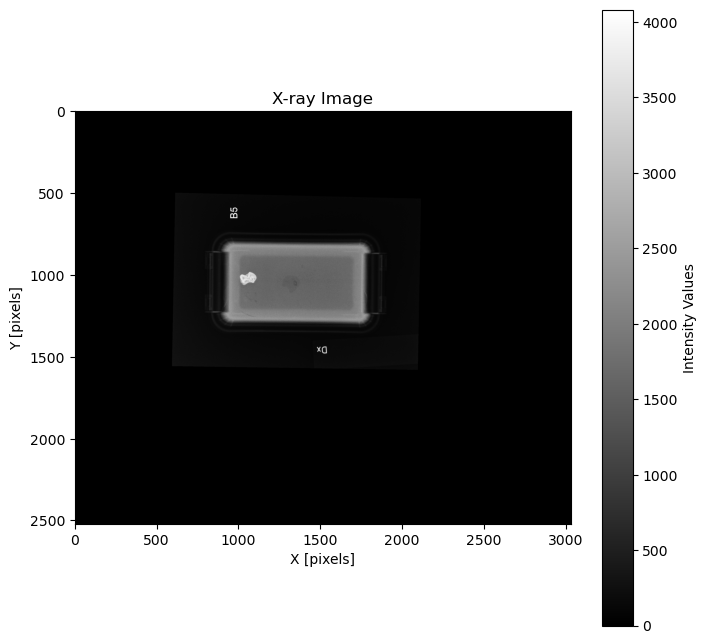

In [41]:
# Load the X-ray image
# Assuming the X-ray image is in NIfTI format for consistency
img = nib.load('Planar X-ray groupB5.nii.gz')  # Replace with your file path
data = img.get_fdata()
info = img.header

# Flip and rotate the image to match radiological convention
img_flip = np.rot90(data, k=2)

# Rotate the image by 90 degrees


# Define plotting parameters
figsize_x, figsize_y = 8, 8
cmap = 'gray'

# Plot the image
plt.figure(figsize=(figsize_x, figsize_y))
plt.imshow(img_flip, cmap=cmap)
plt.title('X-ray Image')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.colorbar(label='Intensity Values')
plt.show()


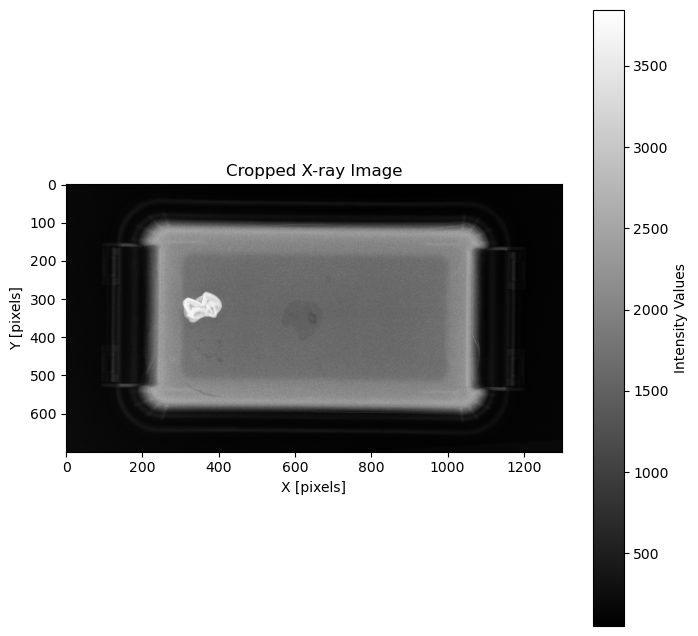

In [42]:
# Define cropping indices (adjust based on your specific image)
x_min, x_max = 700, 1400  # Minimum and maximum x-index
y_min, y_max = 700, 2000  # Minimum and maximum y-index

# Crop the image
data_cropped = img_flip[x_min:x_max, y_min:y_max]

# Plot the cropped and rotated image
plt.figure(figsize=(8, 8))
plt.imshow(data_cropped, cmap=cmap)
plt.title('Cropped X-ray Image')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.colorbar(label='Intensity Values')
plt.show()


In [49]:
def window_level(image, slope, intercept, window, level):
    """
    Apply window leveling to the image after converting raw intensities to HU.
    
    Parameters:
        image (numpy.ndarray): 2D image array with raw intensity values.
        slope (float): Scaling factor (scl_slope) from NIfTI metadata.
        intercept (float): Offset value (scl_inter) from NIfTI metadata.
        window (int): Window width.
        level (int): Window level.
        
    Returns:
        numpy.ndarray: Window-leveled image.
    """
    # Convert raw intensity values to HU
    hu_image = image * slope + intercept

    # Calculate window boundaries
    upper_bound = level + (window / 2)
    lower_bound = level - (window / 2)
    
    # Clip the image values to the window range
    X_clipped = np.clip(hu_image, lower_bound, upper_bound)
    
    # Normalize the clipped values to [0, 1]
    X_WL = (X_clipped - lower_bound) / (upper_bound - lower_bound)
    
    return X_WL, lower_bound, upper_bound


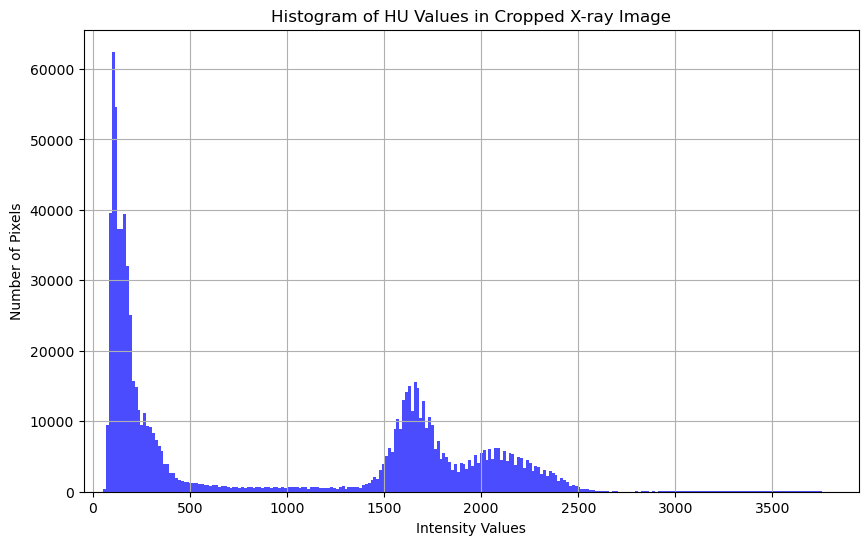

In [50]:
# Plot histogram of the entire cropped image
plt.figure(figsize=(10, 6))
plt.hist(data_cropped.ravel(), bins=256, color='blue', alpha=0.7)
plt.title('Histogram of HU Values in Cropped X-ray Image')
plt.xlabel('Intensity Values')
plt.ylabel('Number of Pixels')
plt.xlim([data_cropped.min()-100, data_cropped.max()+100])  # Adjust based on image
plt.grid(True)
plt.show()


In [46]:
# Obtain pixel dimensions from the NIfTI header
pixel_dims = info.get_zooms()  # (pixel_size_x, pixel_size_y)

print("Pixel dimensions (mm): ", pixel_dims)

# Physical size of the cropped image
img_shape = data_cropped.shape  # (x, y)
img_width_mm = img_shape[0] * pixel_dims[0]
img_height_mm = img_shape[1] * pixel_dims[1]

print(f"Image physical dimensions (mm): Width: {img_width_mm:.2f}, Height: {img_height_mm:.2f}")


Pixel dimensions (mm):  (0.139, 0.139, 1.0)
Image physical dimensions (mm): Width: 97.30, Height: 180.70


___

In [47]:
# Import necessary modules from ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Determine the intensity range of the cropped image
intensity_min = data_cropped.min()
intensity_max = data_cropped.max()

print(f"Intensity range of cropped image: {intensity_min} to {intensity_max}")

# Define default window and level based on data
default_window = 400  # You can adjust this based on your data
default_level = 0      # Starting at 0 or the midpoint of intensity range

# Adjust default level if necessary
if default_level < intensity_min:
    default_level = intensity_min
elif default_level > intensity_max:
    default_level = intensity_max

# Define dynamic slider ranges based on data
window_min = 1
window_max = intensity_max - intensity_min  # Ensures window doesn't exceed data range

level_min = intensity_min
level_max = intensity_max

# Define the window_level function if not already defined
def window_level(image, window, level):
    """
    Apply window leveling to the image.
    
    Parameters:
        image (numpy.ndarray): 2D image array.
        window (int): Window width.
        level (int): Window level.
        
    Returns:
        numpy.ndarray: Window-leveled image.
    """
    upper_bound = level + (window / 2)
    lower_bound = level - (window / 2)
    
    # Clip the image values to the window range
    X_clipped = np.clip(image, lower_bound, upper_bound)
    
    # Normalize the clipped values to [0, 1]
    X_WL = (X_clipped - lower_bound) / (upper_bound - lower_bound)
    
    return X_WL, lower_bound, upper_bound

# Define the interactive update function
def update_window_level(window, level):
    """
    Update the displayed image based on the window and level values.

    Parameters:
        window (int): The window width for window leveling.
        level (int): The window level for window leveling.
    """
    # Apply window leveling to the cropped image
    wl_image, lower, upper = window_level(data_cropped, window, level)
    
    # Clear the previous output to avoid overlapping plots
    with out:
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(wl_image, cmap='gray', vmin=0, vmax=1)
        plt.title(f'Window: {window}, Level: {level}')
        plt.xlabel('X [pixels]')
        plt.ylabel('Y [pixels]')
        plt.colorbar(label='Normalized Intensity')
        plt.show()

# Create sliders for Window and Level with dynamic ranges
window_slider = widgets.IntSlider(
    value=default_window,
    min=window_min,
    max=window_max,
    step=1,
    description='Window:',
    continuous_update=False,
    style={'description_width': 'initial'}
)

level_slider = widgets.FloatSlider(  # Use FloatSlider for more precision if needed
    value=default_level,
    min=level_min,
    max=level_max,
    step=(level_max - level_min) / 1000,  # Adjust step size as needed
    description='Level:',
    continuous_update=False,
    style={'description_width': 'initial'}
)

# Create an Output widget to display the plot
out = widgets.Output()

# Set up observers to call the update function when sliders change
window_slider.observe(lambda change: update_window_level(window_slider.value, level_slider.value), names='value')
level_slider.observe(lambda change: update_window_level(window_slider.value, level_slider.value), names='value')

# Initial plot display
update_window_level(default_window, default_level)

# Arrange sliders vertically and display everything
ui = widgets.VBox([window_slider, level_slider])
display(ui, out)


Intensity range of cropped image: 52.0 to 3844.0


Output()

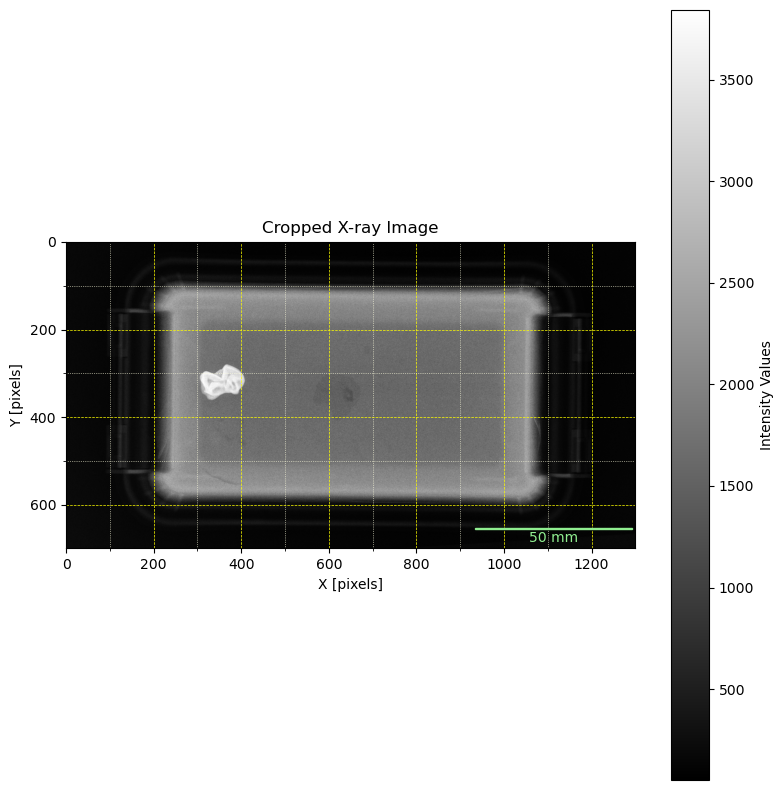

In [48]:
# Import necessary modules for scale bar and grid
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Define cropping indices (adjust based on your specific image)
x_min, x_max = 700, 1400  # Minimum and maximum x-index
y_min, y_max = 700, 2000  # Minimum and maximum y-index

# Crop the image
data_cropped = img_flip[x_min:x_max, y_min:y_max]

# Plot the cropped and rotated image with scale bar and grid
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(data_cropped, cmap=cmap)
ax.set_title('Cropped X-ray Image')
ax.set_xlabel('X [pixels]')
ax.set_ylabel('Y [pixels]')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Intensity Values')

# Define scale bar properties
scale_length_mm = 50  # Desired scale bar length in millimeters
scale_length_px = scale_length_mm / pixel_dims[0]  # Convert mm to pixels

# Create font properties for the scale bar label
fontprops = fm.FontProperties(size=10)

# Create and add the scale bar to the plot
scalebar = AnchoredSizeBar(ax.transData,
                           scale_length_px,                     # Length of the scale bar in pixels
                           f'{scale_length_mm} mm',             # Label for the scale bar
                           'lower right',                      # Location of the scale bar
                           pad=0.1,                             # Padding from the edge
                           color='lightgreen',                      # Color of the scale bar and text
                           frameon=False,                      # No frame around the scale bar
                           size_vertical=1,                    # Thickness of the scale bar
                           fontproperties=fontprops)           # Font properties for the label
ax.add_artist(scalebar)

# Add grid to the plot
# Define grid spacing in pixels (e.g., every 50 pixels)
grid_spacing_px = 200  # Adjust this value based on desired spacing

# Set major grid lines
ax.set_xticks(np.arange(0, data_cropped.shape[1], grid_spacing_px))
ax.set_yticks(np.arange(0, data_cropped.shape[0], grid_spacing_px))

# Enable major grid
ax.grid(which='major', color='yellow', linestyle='--', linewidth=0.5)

# Optionally, add minor grid lines for finer granularity
# Define minor grid spacing (e.g., every 10 pixels)
minor_spacing_px = 100
ax.set_xticks(np.arange(0, data_cropped.shape[1], minor_spacing_px), minor=True)
ax.set_yticks(np.arange(0, data_cropped.shape[0], minor_spacing_px), minor=True)
ax.grid(which='minor', color='lightyellow', linestyle=':', linewidth=0.5)

# Improve layout and display the plot
plt.tight_layout()
plt.show()
